In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df=pd.read_csv("DATA2.csv")
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,SMA,SD,Upper_Band,...,H-L,H-PC,L-PC,ATR,BB_SIGNAL,MACD_SIGNAL_FLAG,RSI_SIGNAL,STOCH_SIGNAL,ATR_SIGNAL,VWAP_SIGNAL
0,0,2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,200500,NaN,NaN,NaN,...,263.349609,NaN,NaN,NaN,0,0,0,0,0,1
1,1,2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,247400,NaN,NaN,NaN,...,234.048828,201.900391,32.148438,NaN,0,1,0,0,0,1
2,2,2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,251500,NaN,NaN,NaN,...,195.849609,139.449219,56.400391,NaN,0,1,0,0,0,1
3,3,2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,236500,NaN,NaN,NaN,...,142.398438,127.300781,269.699219,NaN,0,1,0,0,0,1
4,4,2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,239300,NaN,NaN,NaN,...,200.449219,159.099609,41.349609,NaN,0,1,0,0,0,1


In [5]:


class BacktestEngine:
    def __init__(self, df, signal_col, initial_capital=1000):
        self.df = df.copy()
        self.signal_col = signal_col
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.position = 0
        self.trades = []
        self.portfolio_values = []
        self.returns = []

    def run(self):
        for i in range(1, len(self.df)):
            price = self.df['Open'].iloc[i]
            signal = self.df[self.signal_col].iloc[i-1]
            # Buy
            if signal == 1 and self.position == 0:
                self.position = self.capital / price
                self.capital = 0
                self.trades.append(('Buy', self.df.index[i], price))
            # Sell
            elif signal == -1 and self.position > 0:
                self.capital = self.position * price
                self.position = 0
                self.trades.append(('Sell', self.df.index[i], price))
            # Portfolio value
            if self.position > 0:
                port_val = self.position * price
            else:
                port_val = self.capital
            self.portfolio_values.append(port_val)
            if i > 1:
                self.returns.append((self.portfolio_values[-1] - self.portfolio_values[-2]) / self.portfolio_values[-2])
        # Liquidate at end
        if self.position > 0:
            self.capital = self.position * self.df['Close'].iloc[-1]
            self.position = 0
            self.trades.append(('Sell', self.df.index[-1], self.df['Close'].iloc[-1]))
        return self.summary()

    def summary(self):
        total_return = (self.capital - self.initial_capital) / self.initial_capital
        sharpe = np.mean(self.returns) / np.std(self.returns) * np.sqrt(252) if np.std(self.returns) > 0 else 0
        drawdown = np.max(np.maximum.accumulate(self.portfolio_values) - self.portfolio_values)
        max_drawdown = drawdown / np.max(self.portfolio_values)
        wins = sum(1 for i in range(1, len(self.trades), 2) if self.trades[i][2] > self.trades[i-1][2])
        losses = sum(1 for i in range(1, len(self.trades), 2) if self.trades[i][2] <= self.trades[i-1][2])
        print(f"Total Return: {total_return*100:.2f}%")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Max Drawdown: {max_drawdown*100:.2f}%")
        print(f"Total Trades: {len(self.trades)//2}")
        print(f"Wins: {wins}, Losses: {losses}")
        return {
            'total_return': total_return,
            'sharpe': sharpe,
            'max_drawdown': max_drawdown,
            'total_trades': len(self.trades)//2,
            'wins': wins,
            'losses': losses
        }

    def plot(self):
        plt.figure(figsize=(12,6))
        plt.plot(self.portfolio_values)
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Time')
        plt.ylabel('Portfolio Value')
        plt.show()



BACKTESTING USING BOLLINGER BANDS SIGNAL

Total Return: 26.12%
Sharpe Ratio: 0.82
Max Drawdown: 12.88%
Total Trades: 7
Wins: 5, Losses: 2


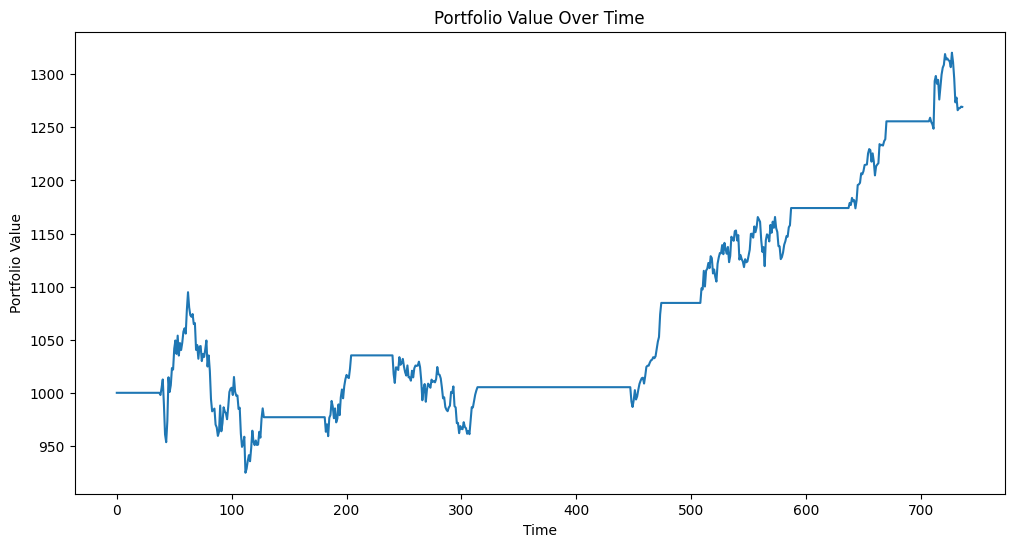

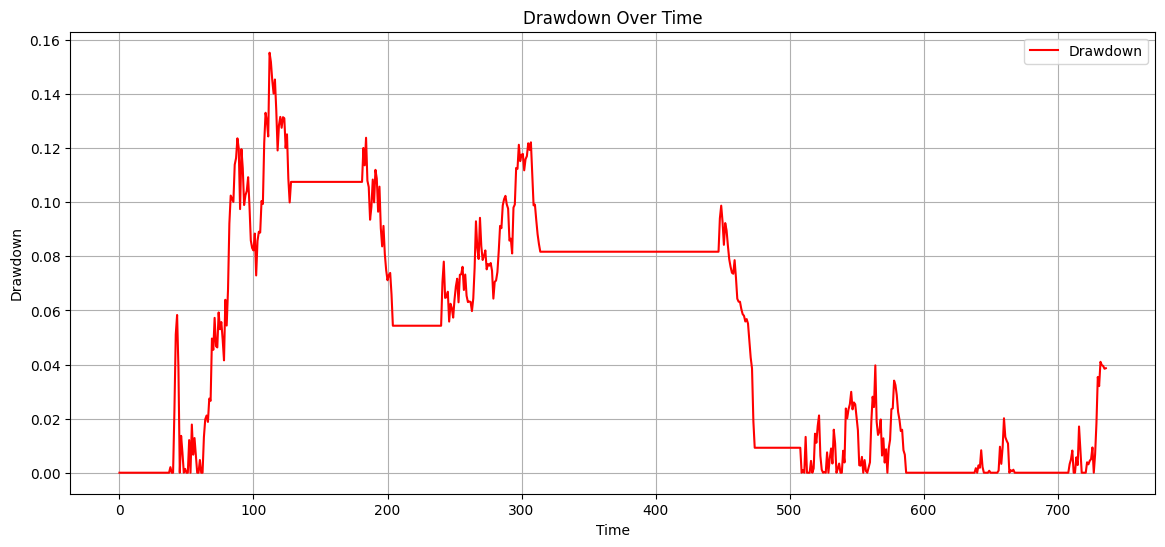

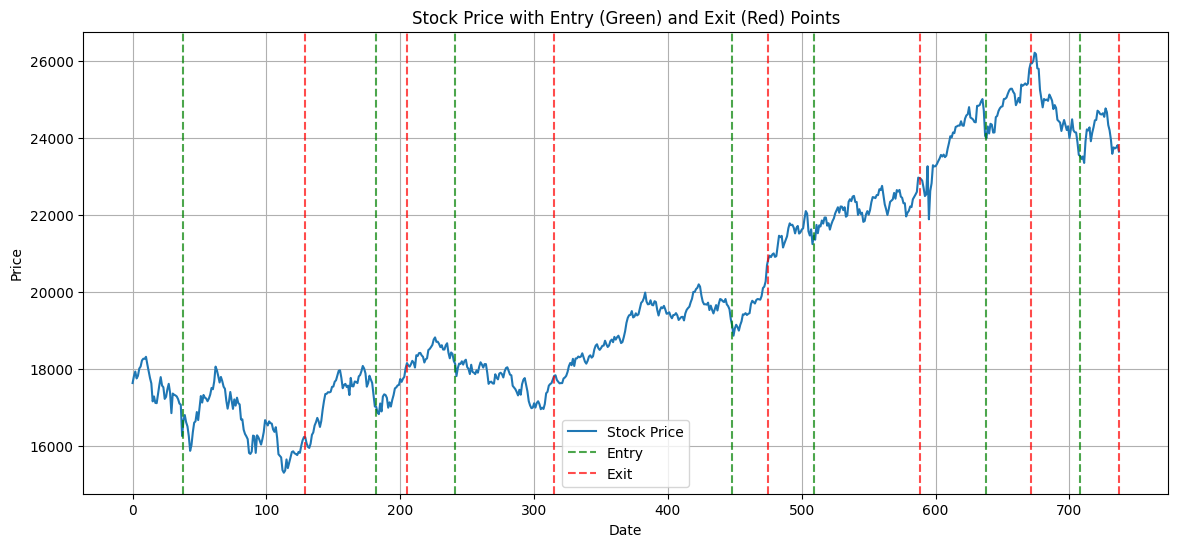

In [8]:

bt = BacktestEngine(df, 'BB_SIGNAL')
results = bt.run()
bt.plot()

portfolio_values = np.array(bt.portfolio_values)
roll_max = np.maximum.accumulate(portfolio_values)
drawdown = (roll_max - portfolio_values) / roll_max

plt.figure(figsize=(14, 6))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plot stock price with entry and exit points
entries = [trade[1] for trade in bt.trades if trade[0] == 'Buy']
exits = [trade[1] for trade in bt.trades if trade[0] == 'Sell']

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Stock Price')

for entry in entries:
    plt.axvline(x=entry, color='green', linestyle='--', alpha=0.7, label='Entry' if entry == entries[0] else "")

for exit in exits:
    plt.axvline(x=exit, color='red', linestyle='--', alpha=0.7, label='Exit' if exit == exits[0] else "")

plt.title('Stock Price with Entry (Green) and Exit (Red) Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Total Return: 15.41%
Sharpe Ratio: 0.57
Max Drawdown: 9.05%
Total Trades: 28
Wins: 11, Losses: 17


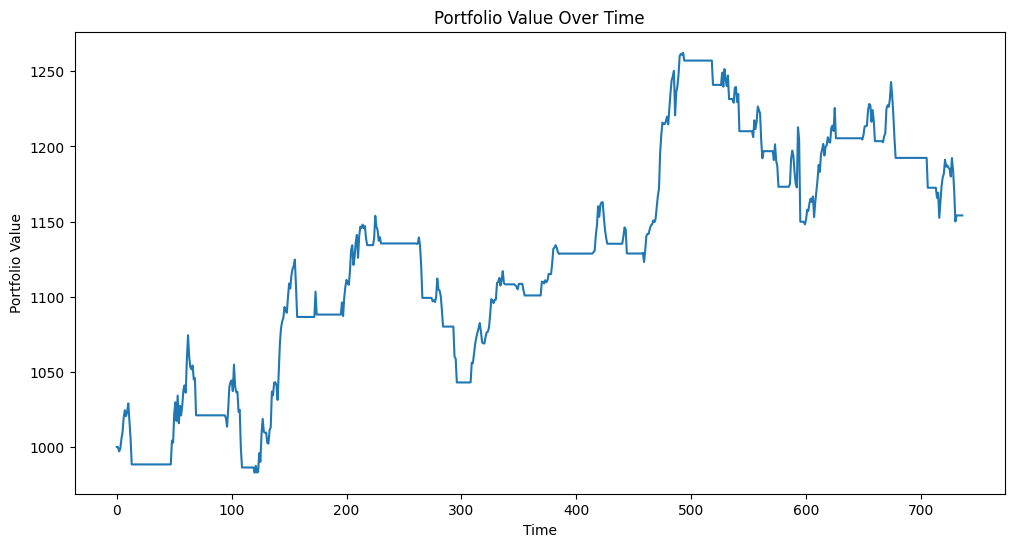

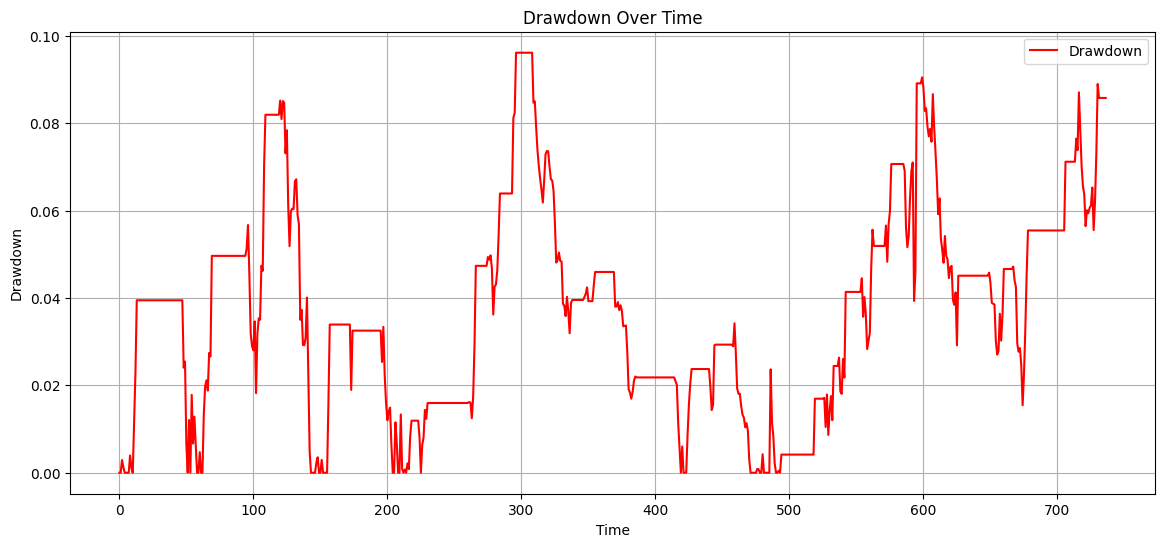

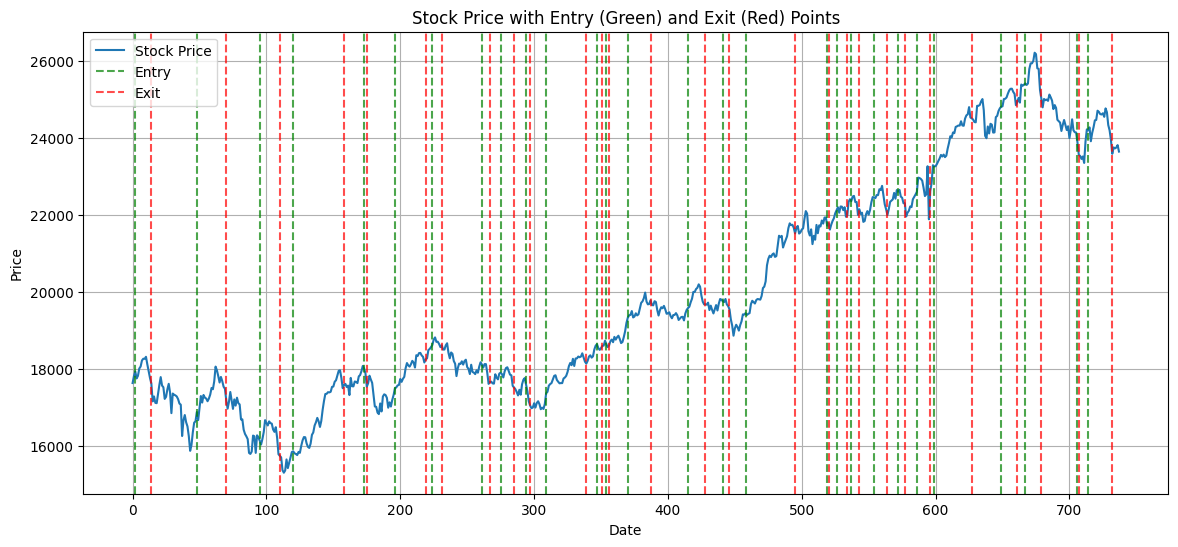

In [9]:

bt = BacktestEngine(df, 'MACD_SIGNAL_FLAG')
results = bt.run()
bt.plot()

portfolio_values = np.array(bt.portfolio_values)
roll_max = np.maximum.accumulate(portfolio_values)
drawdown = (roll_max - portfolio_values) / roll_max

plt.figure(figsize=(14, 6))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plot stock price with entry and exit points
entries = [trade[1] for trade in bt.trades if trade[0] == 'Buy']
exits = [trade[1] for trade in bt.trades if trade[0] == 'Sell']

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Stock Price')

for entry in entries:
    plt.axvline(x=entry, color='green', linestyle='--', alpha=0.7, label='Entry' if entry == entries[0] else "")

for exit in exits:
    plt.axvline(x=exit, color='red', linestyle='--', alpha=0.7, label='Exit' if exit == exits[0] else "")

plt.title('Stock Price with Entry (Green) and Exit (Red) Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Total Return: 4.21%
Sharpe Ratio: 0.22
Max Drawdown: 9.76%
Total Trades: 8
Wins: 5, Losses: 3


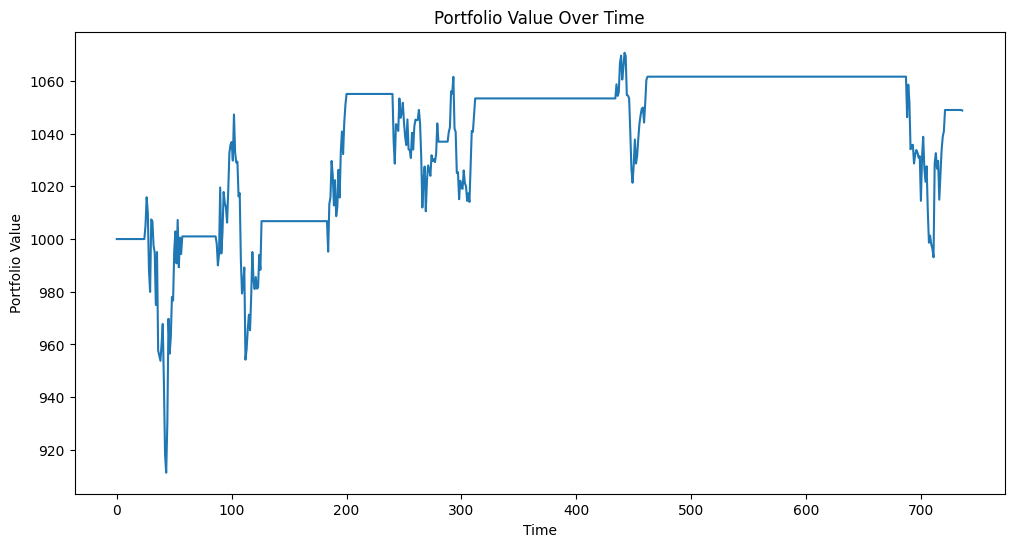

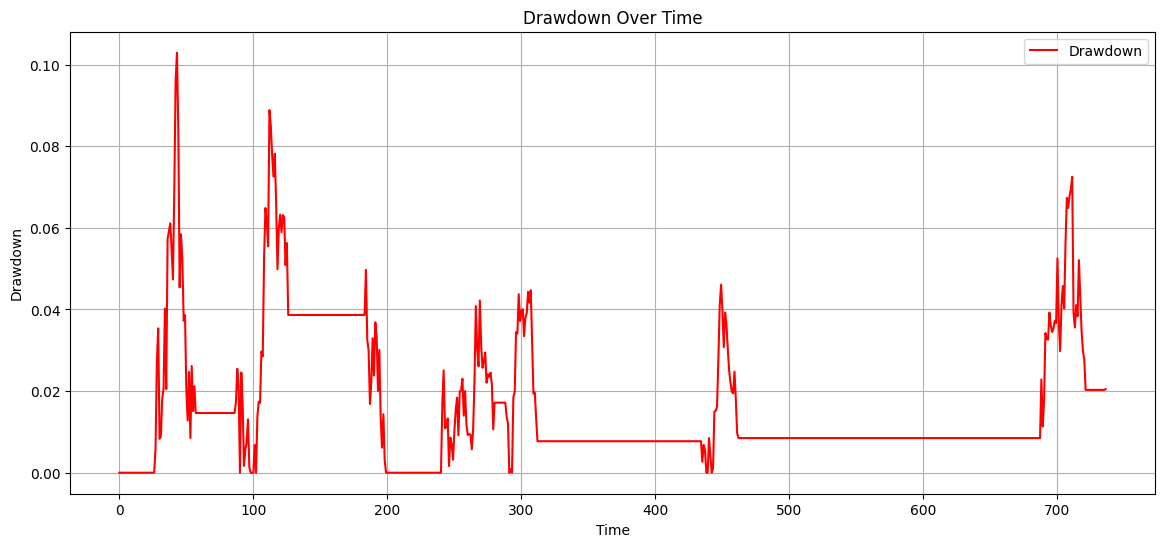

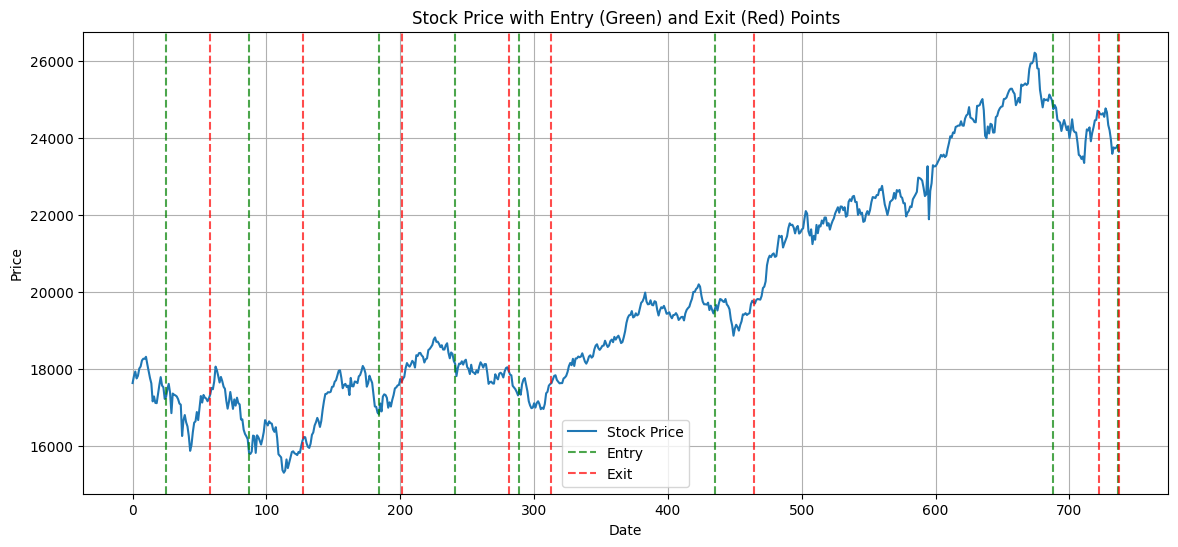

In [10]:

bt = BacktestEngine(df, 'RSI_SIGNAL')
results = bt.run()
bt.plot()

portfolio_values = np.array(bt.portfolio_values)
roll_max = np.maximum.accumulate(portfolio_values)
drawdown = (roll_max - portfolio_values) / roll_max

plt.figure(figsize=(14, 6))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plot stock price with entry and exit points
entries = [trade[1] for trade in bt.trades if trade[0] == 'Buy']
exits = [trade[1] for trade in bt.trades if trade[0] == 'Sell']

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Stock Price')

for entry in entries:
    plt.axvline(x=entry, color='green', linestyle='--', alpha=0.7, label='Entry' if entry == entries[0] else "")

for exit in exits:
    plt.axvline(x=exit, color='red', linestyle='--', alpha=0.7, label='Exit' if exit == exits[0] else "")

plt.title('Stock Price with Entry (Green) and Exit (Red) Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Total Return: 13.12%
Sharpe Ratio: 0.64
Max Drawdown: 8.25%
Total Trades: 7
Wins: 4, Losses: 3


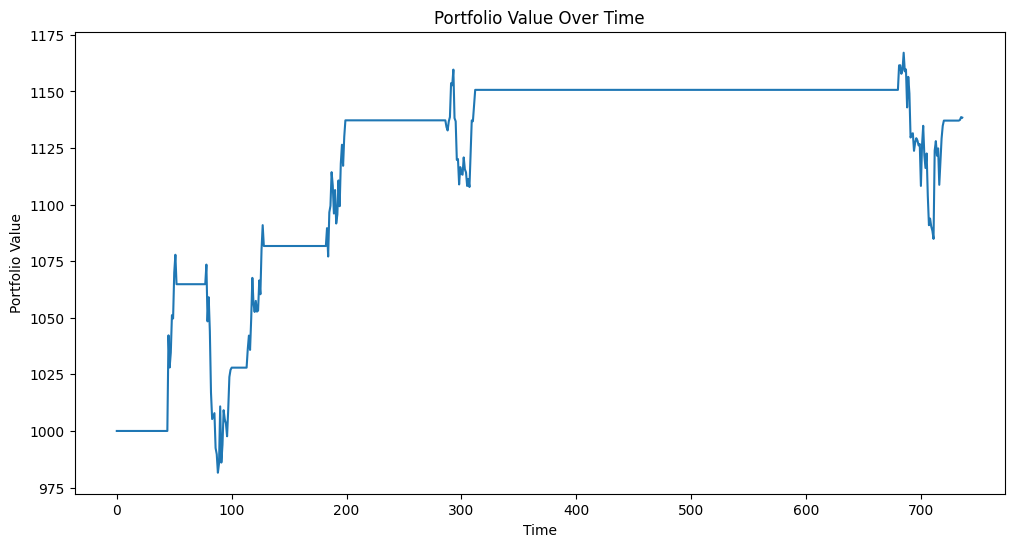

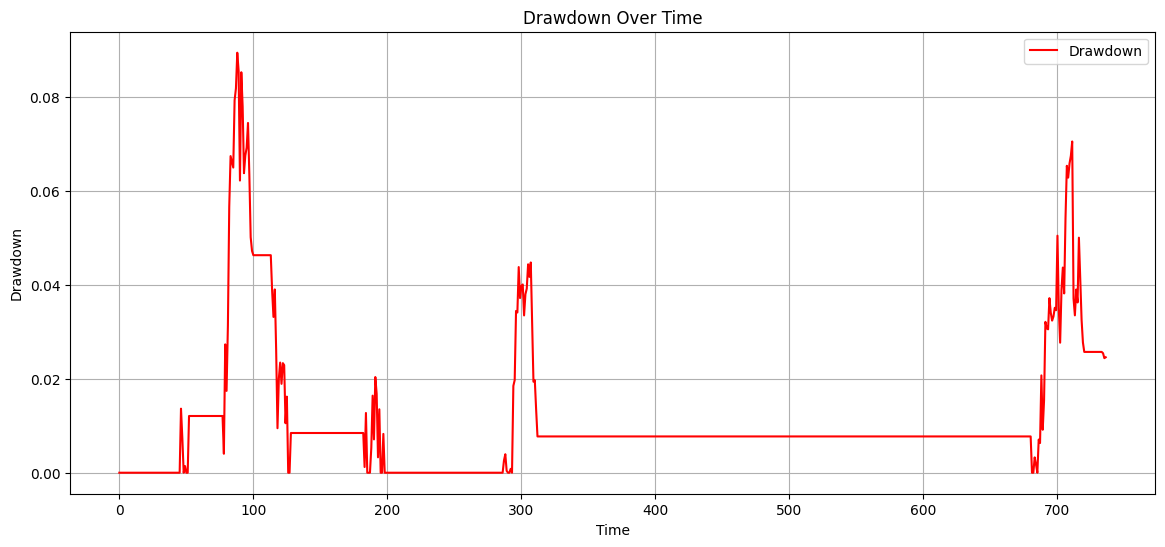

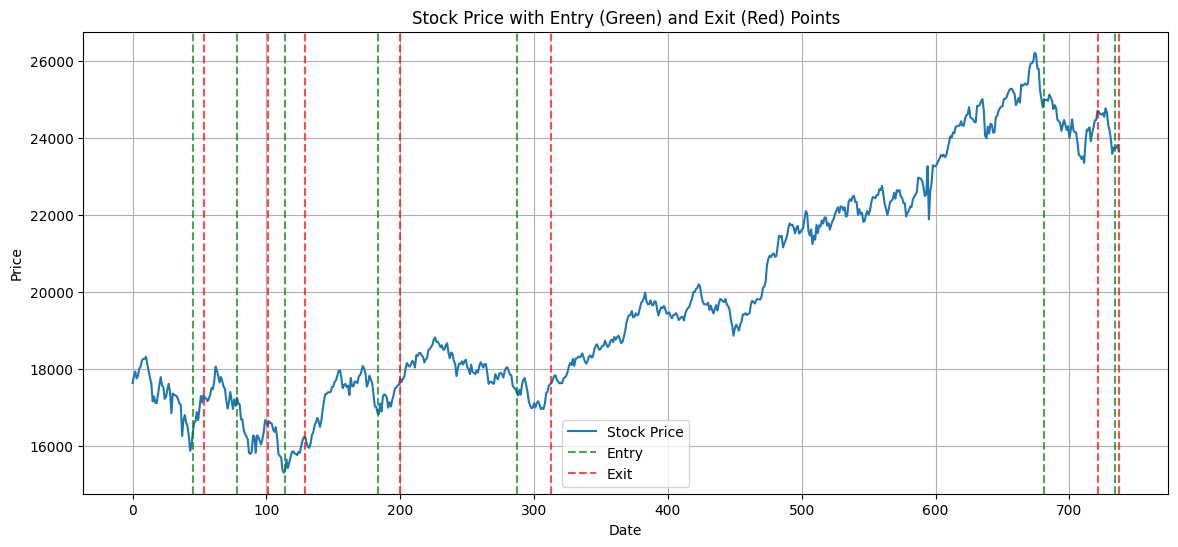

In [11]:

bt = BacktestEngine(df, 'STOCH_SIGNAL')
results = bt.run()
bt.plot()

portfolio_values = np.array(bt.portfolio_values)
roll_max = np.maximum.accumulate(portfolio_values)
drawdown = (roll_max - portfolio_values) / roll_max

plt.figure(figsize=(14, 6))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plot stock price with entry and exit points
entries = [trade[1] for trade in bt.trades if trade[0] == 'Buy']
exits = [trade[1] for trade in bt.trades if trade[0] == 'Sell']

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Stock Price')

for entry in entries:
    plt.axvline(x=entry, color='green', linestyle='--', alpha=0.7, label='Entry' if entry == entries[0] else "")

for exit in exits:
    plt.axvline(x=exit, color='red', linestyle='--', alpha=0.7, label='Exit' if exit == exits[0] else "")

plt.title('Stock Price with Entry (Green) and Exit (Red) Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Total Return: 26.56%
Sharpe Ratio: 0.75
Max Drawdown: 10.81%
Total Trades: 10
Wins: 3, Losses: 7


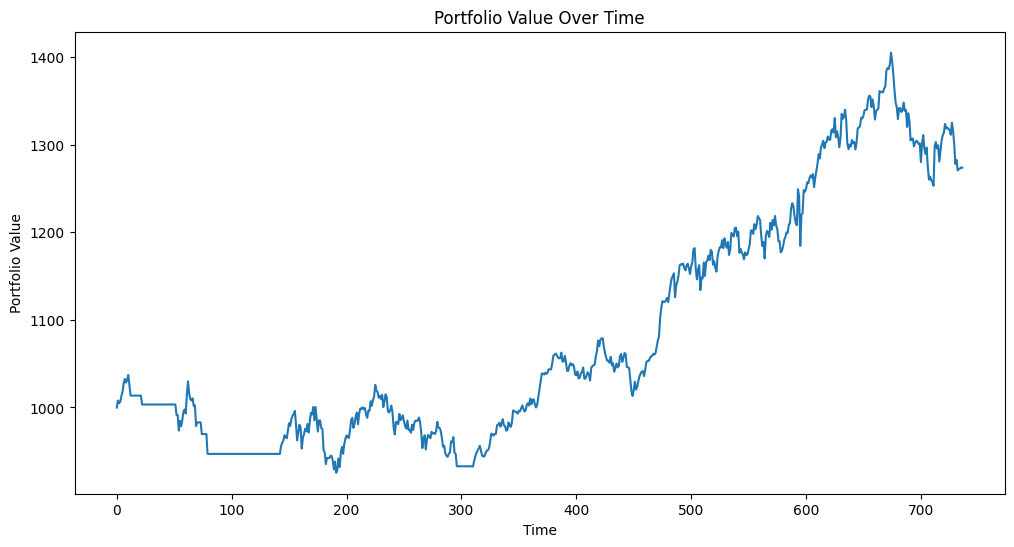

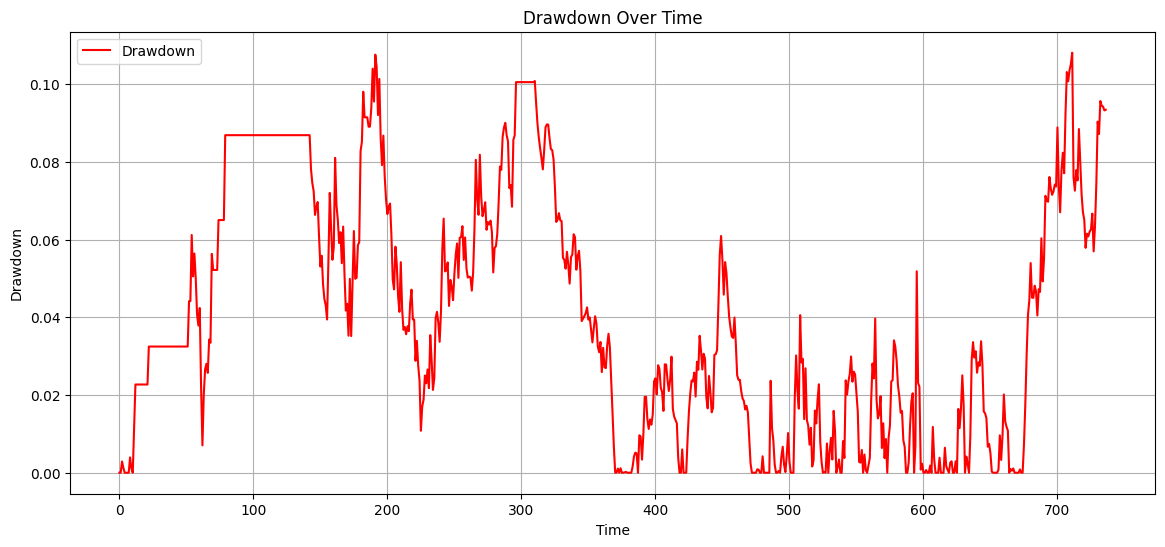

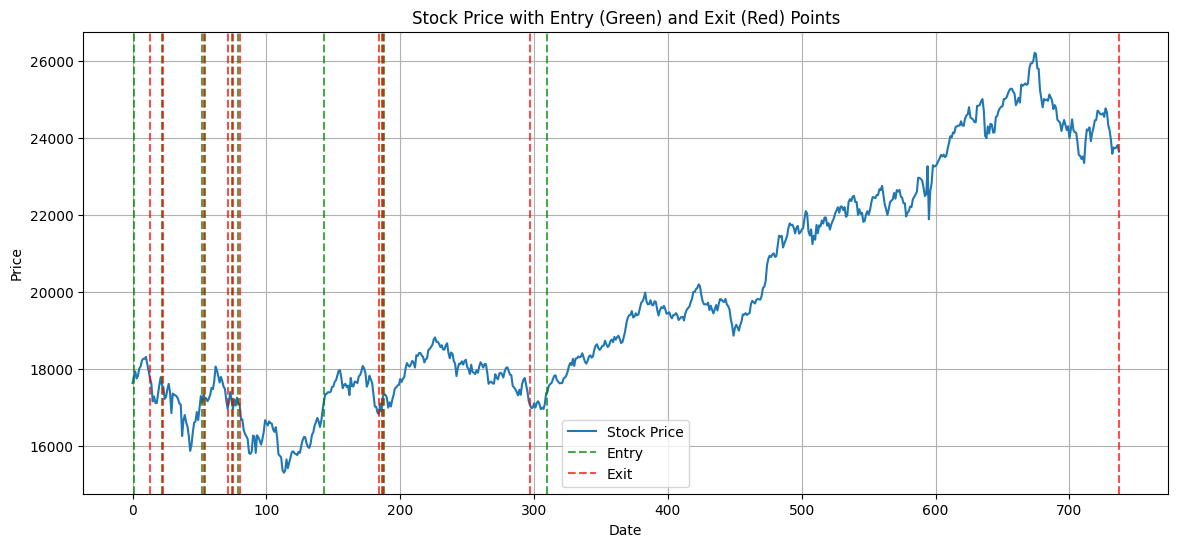

In [12]:

bt = BacktestEngine(df, 'VWAP_SIGNAL')
results = bt.run()
bt.plot()

portfolio_values = np.array(bt.portfolio_values)
roll_max = np.maximum.accumulate(portfolio_values)
drawdown = (roll_max - portfolio_values) / roll_max

plt.figure(figsize=(14, 6))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plot stock price with entry and exit points
entries = [trade[1] for trade in bt.trades if trade[0] == 'Buy']
exits = [trade[1] for trade in bt.trades if trade[0] == 'Sell']

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Stock Price')

for entry in entries:
    plt.axvline(x=entry, color='green', linestyle='--', alpha=0.7, label='Entry' if entry == entries[0] else "")

for exit in exits:
    plt.axvline(x=exit, color='red', linestyle='--', alpha=0.7, label='Exit' if exit == exits[0] else "")

plt.title('Stock Price with Entry (Green) and Exit (Red) Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Total Return: 34.24%
Sharpe Ratio: 0.77
Max Drawdown: 10.81%
Total Trades: 1
Wins: 1, Losses: 0


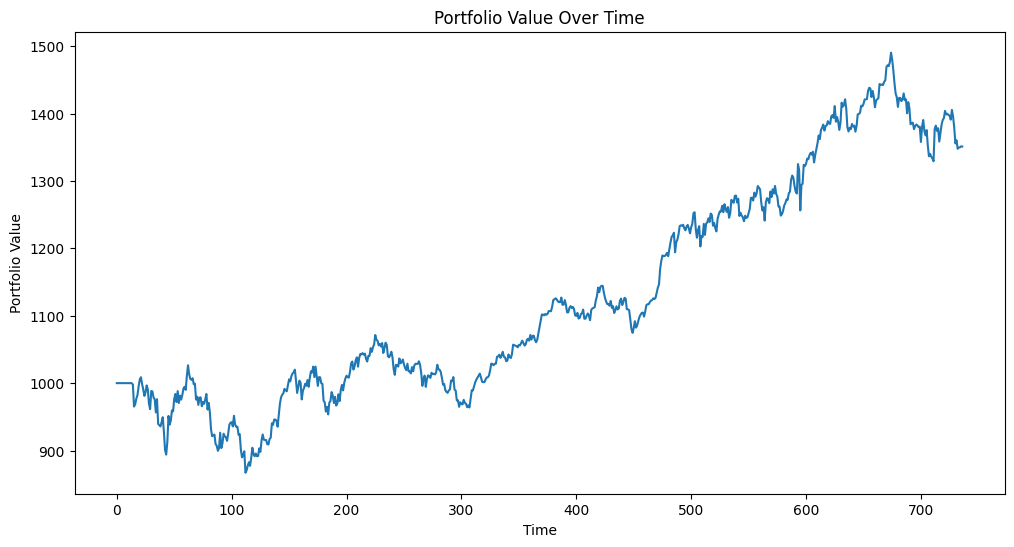

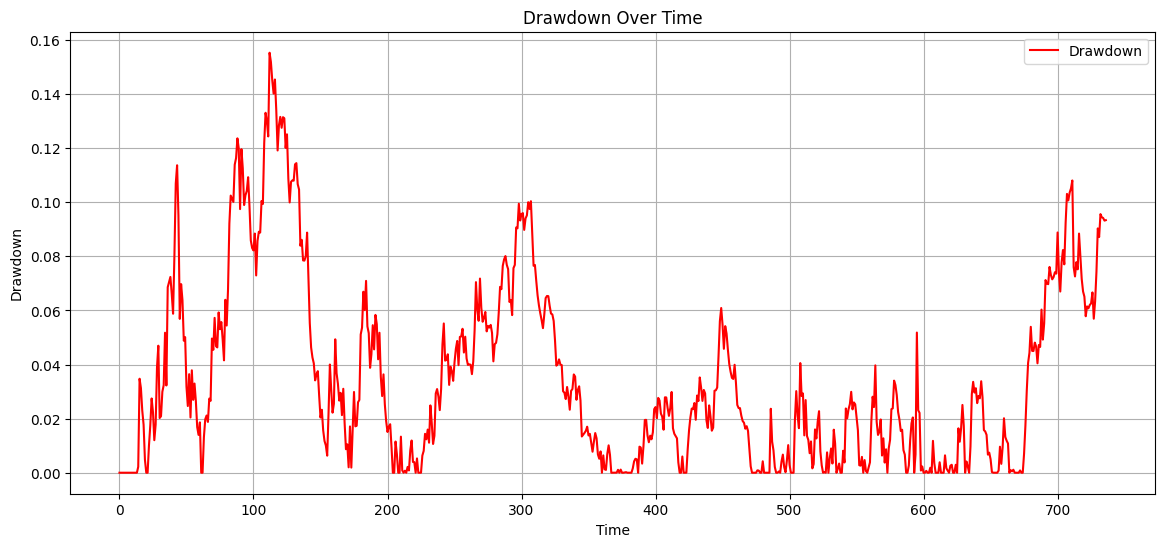

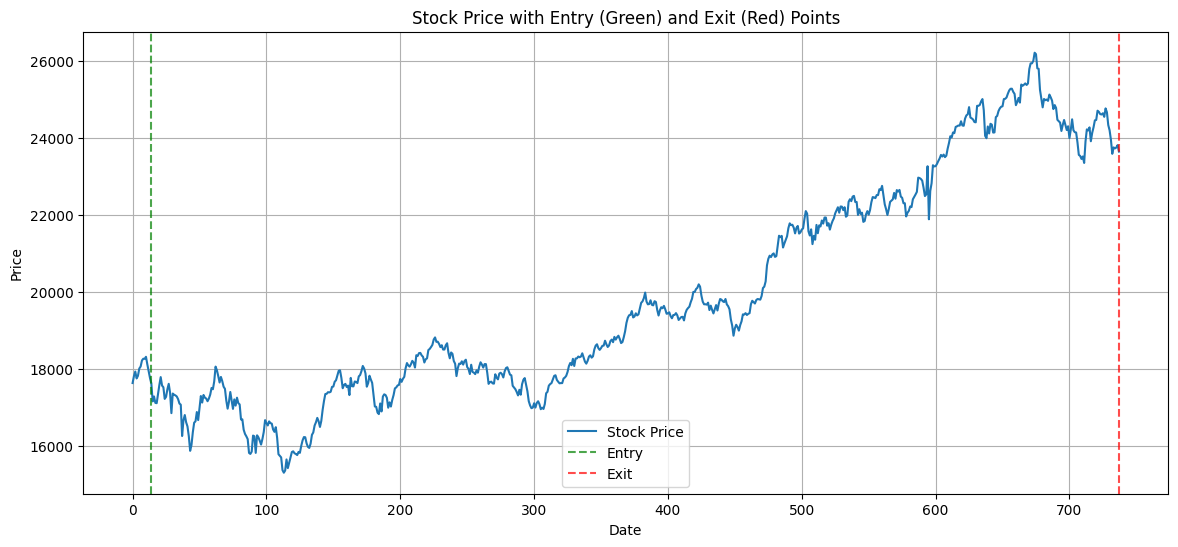

In [13]:

bt = BacktestEngine(df, 'ATR_SIGNAL')
results = bt.run()
bt.plot()

portfolio_values = np.array(bt.portfolio_values)
roll_max = np.maximum.accumulate(portfolio_values)
drawdown = (roll_max - portfolio_values) / roll_max

plt.figure(figsize=(14, 6))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plot stock price with entry and exit points
entries = [trade[1] for trade in bt.trades if trade[0] == 'Buy']
exits = [trade[1] for trade in bt.trades if trade[0] == 'Sell']

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Stock Price')

for entry in entries:
    plt.axvline(x=entry, color='green', linestyle='--', alpha=0.7, label='Entry' if entry == entries[0] else "")

for exit in exits:
    plt.axvline(x=exit, color='red', linestyle='--', alpha=0.7, label='Exit' if exit == exits[0] else "")

plt.title('Stock Price with Entry (Green) and Exit (Red) Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()